# GLCP

In [1]:
from shiori.utils.viewer import set_plot_params, sns, plt
from shiori.utils.path import ProjectPath
from pathlib import Path
import numpy as np
import cv2
set_plot_params()
name = Path().cwd().name + "/GLCP"
proj = ProjectPath(save_dst=name)
save_dir = proj.save_dir
save_dir.mkdir(parents=True, exist_ok=True)
plt.rcParams.update({
    "text.usetex": True,               # LaTeXを使う
    "font.family": "Arial",            # セリフ体
    "font.serif": ["Computer Modern"], # LaTeX標準フォント
})


In [18]:
def extract_endpoints(skel: np.ndarray) -> np.ndarray:
    bin_skel = (skel > 0).astype(np.uint8)
    kernel = np.ones((3, 3), np.uint8)
    neighbor_count = cv2.filter2D(bin_skel, -1, kernel)
    endpoints = np.logical_and(bin_skel == 1, neighbor_count == 2)
    return endpoints.astype(np.uint8)

In [19]:
# 1. ダミーのスケルトン画像を作成
H, W = 256, 256

In [27]:
skel1 = np.zeros((H, W), dtype=np.uint8)
cv2.line(skel1, (120, 200), (120, 80), 255, 1)
cv2.line(skel1, (120, 120), (180, 60), 255, 1)
pts = np.array([[50, 50], [70, 70], [90, 60], [110, 65]], np.int32).reshape((-1, 1, 2))
cv2.polylines(skel1, [pts], False, 255, 1)
endpoints1 = extract_endpoints(skel1)
vis1 = cv2.cvtColor(skel1, cv2.COLOR_GRAY2BGR)
ys, xs = np.where(endpoints1 == 1)
for x, y in zip(xs, ys):
    cv2.circle(vis1, (x, y), 4, (0, 255, 255), thickness=-1)  # 黄(BGR)

In [38]:
skel2 = np.zeros((H, W), dtype=np.uint8)
cv2.line(skel2, (120, 200), (120, 80), 255, 1)
cv2.line(skel2, (120, 120), (180, 60), 255, 1)
pts = np.array([[50, 50], [70, 70], [90, 60], [110, 65], [120, 80]], np.int32).reshape((-1, 1, 2))
cv2.polylines(skel2, [pts], False, 255, 1)
endpoints2 = extract_endpoints(skel2)
vis2 = cv2.cvtColor(skel2, cv2.COLOR_GRAY2BGR)
ys, xs = np.where(endpoints2 == 1)
for x, y in zip(xs, ys):
    cv2.circle(vis2, (x, y), 4, (0, 255, 255), thickness=-1)  # 黄(BGR)

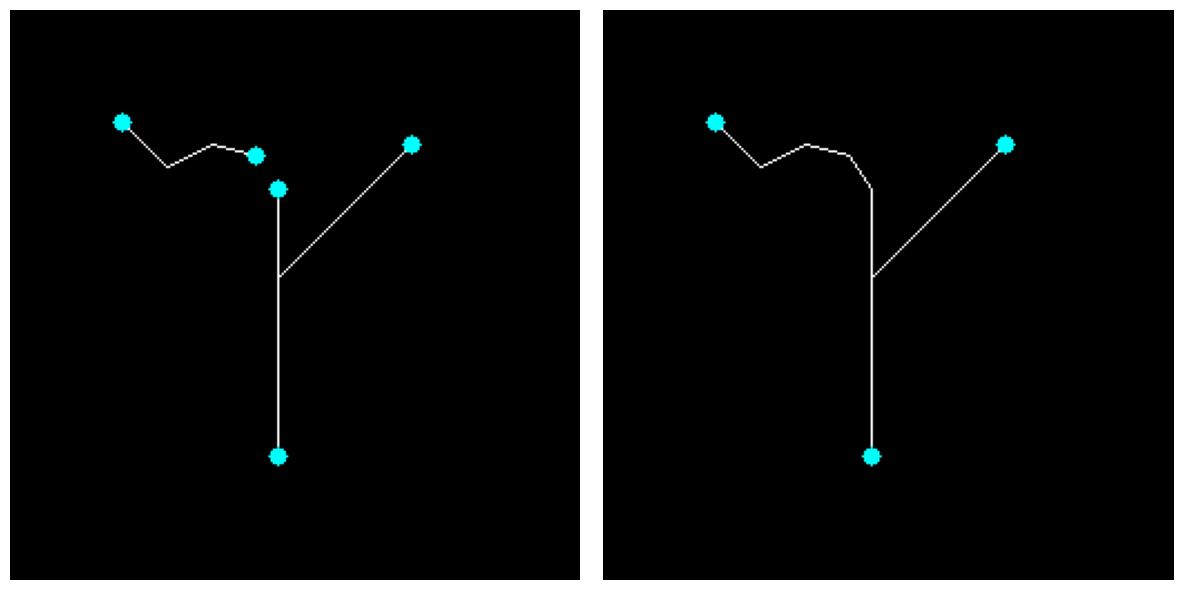

In [46]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(vis1)
plt.axis("off")
plt.subplot(122)
plt.imshow(vis2)
plt.axis("off")
plt.tight_layout()
plt.savefig(save_dir.joinpath("endpoints.png"), dpi=300, facecolor="white")
plt.show()

In [ ]:
bin_skel = (skel > 0).astype(np.uint8)
kernel = np.ones((3, 3), np.uint8)
neighbor_count = cv2.filter2D(bin_skel, -1, kernel)

# skeltonが1かつ近接数が2
endpoints = np.logical_and(bin_skel == 1, neighbor_count == 2)

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

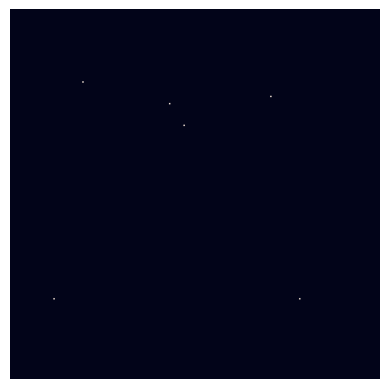